# Importing  libraries

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from zipfile import ZipFile
import cv2
from google.colab.patches import cv2_imshow






Setting Up Kaggle and Downloading the Dataset

In [2]:
# Kaggle Setup and Dataset Download
!pip install kaggle


In [3]:
# Configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset from Kaggle
!kaggle datasets download -d omkargurav/face-mask-dataset


Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 99% 161M/163M [00:00<00:00, 186MB/s]
100% 163M/163M [00:00<00:00, 187MB/s]


In [5]:
# Extract the dataset
dataset = '/content/face-mask-dataset.zip'
with ZipFile(dataset, 'r') as zip_ref:
    zip_ref.extractall()
    print("Dataset extracted successfully!")

Dataset extracted successfully!


Data Preparation

In [6]:
with_mask_files = os.listdir('/content/data/with_mask')
without_mask_files = os.listdir('/content/data/without_mask')


In [7]:
#Labels for the categories :
#1 : With_mask
#0 : Without_mask

with_mask_labels = [1] * len(with_mask_files)
without_mask_labels = [0] * len(without_mask_files)



In [8]:
# Paths to images
with_mask_path = '/content/data/with_mask/'
without_mask_path = '/content/data/without_mask/'


The images are resized to (128, 128) pixels and converted to RGB format. This standardization is necessary for training the model.

In [9]:
# Prepare data and labels
data = []
labels = []

for img_file in with_mask_files:
    image = Image.open(with_mask_path + img_file)
    image = image.resize((128, 128))
    image = image.convert('RGB')
    data.append(np.array(image))
    labels.append(1)

for img_file in without_mask_files:
    image = Image.open(without_mask_path + img_file)
    image = image.resize((128, 128))
    image = image.convert('RGB')
    data.append(np.array(image))
    labels.append(0)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Splitting the Data

In [10]:

# Convert to numpy arrays
X = np.array(data)
Y = np.array(labels)


In [11]:
# Split the data into training, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=2)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=2)


Scaling data

In [12]:
# Scale the data
X_train_scaled = X_train / 255.0
X_val_scaled = X_val / 255.0
X_test_scaled = X_test / 255.0


**Data Augmentation**

Artificially expand the size of a training dataset by creating modified versions of images in the dataset.

In [13]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,        # Randomly rotate images in the range 0-40 degrees
    width_shift_range=0.2,    # Randomly shift the image horizontally by 20% of the width
    height_shift_range=0.2,   # Randomly shift the image vertically by 20% of the height
    shear_range=0.2,          # Randomly apply a shear transformation (similar to slanting)
    zoom_range=0.2,           # Randomly zoom in on the images by up to 20%
    horizontal_flip=True,     # Randomly flip half the images horizontally (left to right)
    fill_mode='nearest'       # Filling in pixels when the image is rotated or shifted
)


In [14]:
# Create the training and validation data generators
train_generator = train_datagen.flow(X_train_scaled, Y_train, batch_size=32)
val_generator = ImageDataGenerator().flow(X_val_scaled, Y_val, batch_size=32)



Building CNN

In [15]:
# Model Architecture
model = keras.Sequential([
    #Input layer :
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    #Hidden layers :
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #Flatting layer( Converts the 2D feature maps into a 1D vector) :
    layers.Flatten(),

    #Dense layers (Fully connected layers):
    layers.Dense(128, activation='relu'),#128 neurons
    layers.Dropout(0.5), #andomly drops 50% of the neurons(prevents the overfitting)
    layers.Dense(64, activation='relu'), #Another dense layer with 64 neurons
    layers.Dropout(0.5),

    #Output layer :
    layers.Dense(1, activation='sigmoid') #It outputs a probability value between 0 and 1, Sigmoid activation function is used for binary classification
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the model

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Train the model

In [17]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


166/166 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.6126 - loss: 0.6435 - val_accuracy: 0.8658 - val_loss: 0.3452
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.8151 - loss: 0.4356 - val_accuracy: 0.8773 - val_loss: 0.3174
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.8188 - loss: 0.4251 - val_accuracy: 0.8870 - val_loss: 0.2900
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8360 - loss: 0.3901 - val_accuracy: 0.8897 - val_loss: 0.2710
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.8505 - loss: 0.3563 - val_accuracy: 0.9091 - val_loss: 0.2564
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.8641 - loss: 0.3359 - val_accuracy: 0.9056 - val_loss: 0.2512
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8640 - loss: 0.3085 - val_accuracy: 0.9197 - val_loss: 0.2370
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.8769 - loss: 0.3097 - val_accuracy: 0.926

Evaluation

In [18]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print(f'Test Accuracy = {accuracy * 100:.2f}%')


36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 425ms/step - accuracy: 0.9359 - loss: 0.1648
Test Accuracy = 93.03%


Visualization

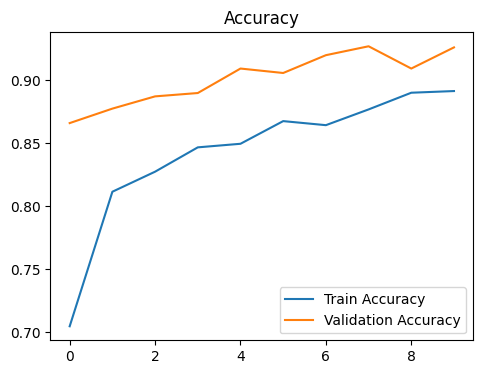

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()


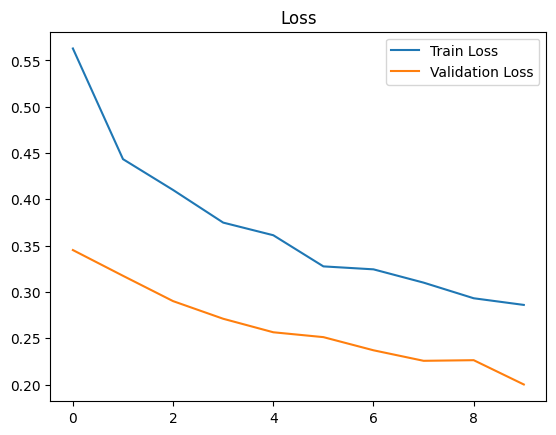

In [20]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

Predictive System

36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 284ms/step


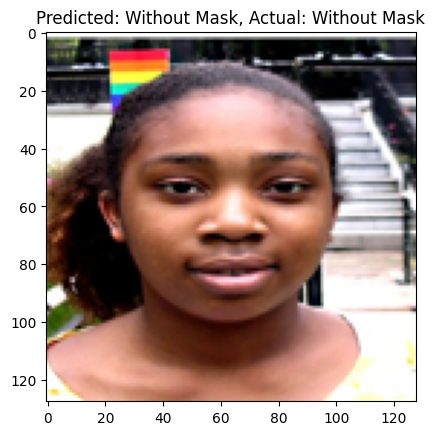

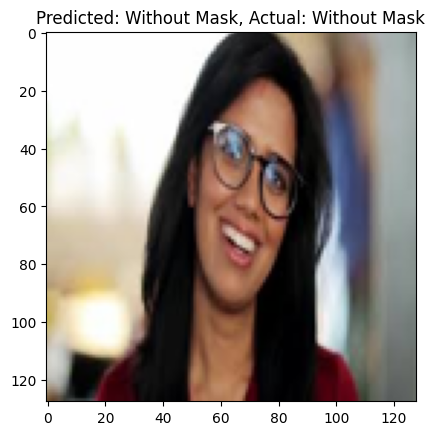

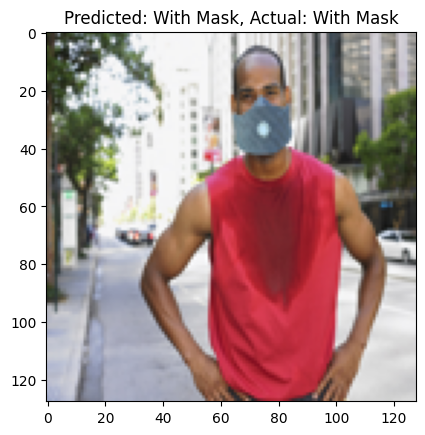

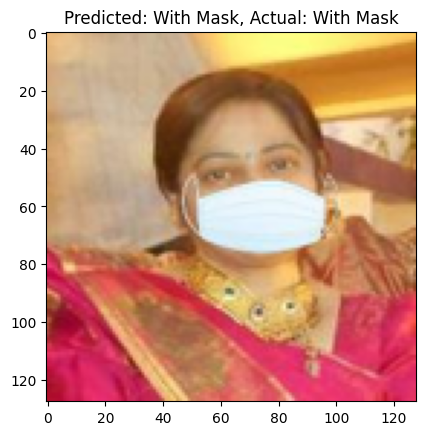

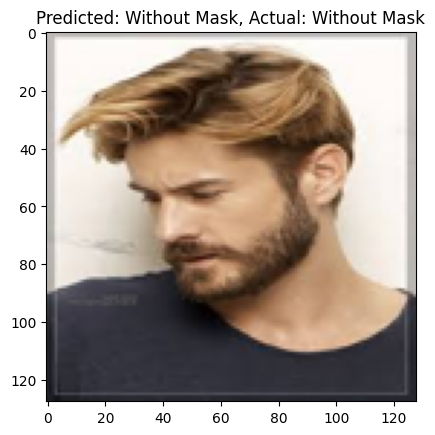

In [21]:
# Predicting with the model
predictions = model.predict(X_test_scaled)
predictions = [1 if p > 0.5 else 0 for p in predictions]

# Display a few test images with predictions
for i in range(5):
    plt.imshow(X_test[i])
    plt.title(f'Predicted: {"With Mask" if predictions[i] == 1 else "Without Mask"}, Actual: {"With Mask" if Y_test[i] == 1 else "Without Mask"}')
    plt.show()